# ART for scikit-learn LogisticRegression

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris

import numpy as np
from matplotlib import pyplot as plt

from art.classifiers import SklearnSVC
from art.attacks.projected_gradient_descent import ProjectedGradientDescent
from art.utils import load_mnist

In [2]:
plt.rcParams['figure.figsize'] = [10, 10]

# Training scikit-learn SVC and attacking with ART Projected Gradient Descent

In [3]:
def get_adversarial_examples(x_train, kernel):
    
    # Create scikit-learn SVC
    skl_svc = SVC(C=1.0, kernel=kernel, degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None)
    
    # Fit SVC
    skl_svc.fit(X=x_train, y=y_train)
    
    # Create ART classfier for scikit-learn SVC
    art_svc = SklearnSVC(clip_values=(-100, 100), model=skl_svc)
    
    # Create ART Projected Gradient Descent attack
    pgd = ProjectedGradientDescent(classifier=art_svc, norm=1, eps=1.0, eps_step=1, max_iter=1, targeted=False, num_random_init=0, batch_size=200)
    
    # Generate adversarial samples with ART Projected Gradient attack
    x_train_adv = pgd.generate(x_train)
    
    return x_train_adv, skl_svc

# Utility functions

In [4]:
def get_data(num_classes):
    x_train, y_train = load_iris(return_X_y=True)
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] -= 2
    x_train[:, 1][y_train == 2] += 2
    return x_train, y_train

In [5]:
def plot_results(skl_svc, x_train, y_train, x_train_adv, num_classes):
    
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))
#     fig.suptitle('Vertically stacked subplots')

    colors = ['orange', 'blue', 'green']
    
    for i_class in range(num_classes):
        
        # Plot difference vectors
        for i in range(y_train[y_train==i_class].shape[0]):
            x_1_0 = x_train[y_train==i_class][i, 0]
            x_1_1 = x_train[y_train==i_class][i, 1]
            x_2_0 = x_train_adv[y_train==i_class][i, 0]
            x_2_1 = x_train_adv[y_train==i_class][i, 1]
            axs[i_class].plot([x_1_0, x_2_0], [x_1_1, x_2_1], c='black', zorder=1)
        
        # Plot benign samples
        for i_class_2 in range(num_classes):
            axs[i_class].scatter(x_train[y_train==i_class_2][:, 0], x_train[y_train==i_class_2][:, 1], zorder=2, c=colors[i_class_2])
        axs[i_class].set_aspect('equal', adjustable='box')

        # Mark support vectors with circles
        for sv in skl_svc.support_vectors_:
            axs[i_class].scatter(sv[0], sv[1], s=250, facecolors='none', edgecolors='r', zorder=2)

        # Show SVC predicted probability as contour plot
        h = .01
        x_min, x_max = 1.5, 8.5
        y_min, y_max = 0, 7

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        if skl_svc.probability:
            Z_proba = skl_svc.predict_proba(np.c_[xx.ravel(), yy.ravel()])
            Z_proba = Z_proba[:, i_class].reshape(xx.shape)
            axs[i_class].contourf(xx, yy, Z_proba, vmin=0, vmax=1)
        else:
            Z = skl_svc.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            axs[i_class].contour(xx, yy, Z, cmap=plt.cm.Paired)
    
        # Plot adversarial samples
        axs[i_class].scatter(x_train_adv[y_train==i_class][:, 0], x_train_adv[y_train==i_class][:, 1], zorder=2, c='red', marker='X')
        axs[i_class].set_xlim((x_min, x_max))
        axs[i_class].set_ylim((y_min, y_max))

# Example Iris dataset

## linear kernel, binary classification

np.unique(y)
[0. 1.]
np.unique(y_index)
[0 1]
sign_multiplier 1


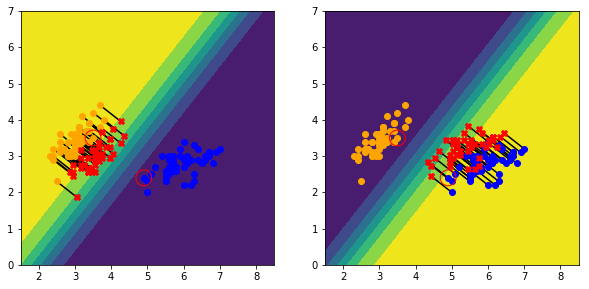

In [6]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, skl_svc = get_adversarial_examples(x_train, kernel='linear')
plot_results(skl_svc, x_train, y_train, x_train_adv, num_classes)

## linear kernel, multi-classification

np.unique(y)
[0. 1.]
np.unique(y_index)
[0 1 2]
sign_multiplier -1


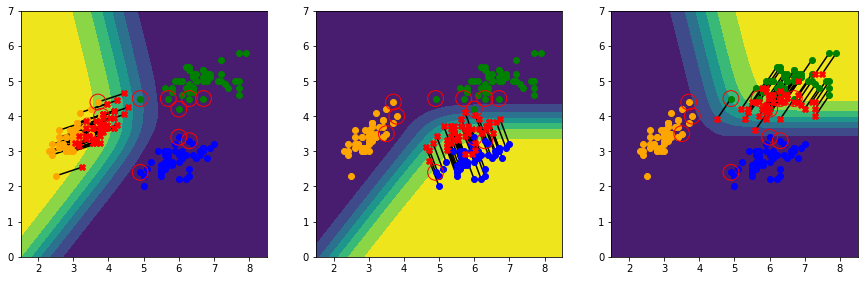

In [7]:
num_classes = 3
x_train, y_train = get_data(num_classes)
x_train_adv, skl_svc = get_adversarial_examples(x_train, kernel='linear')
plot_results(skl_svc, x_train, y_train, x_train_adv, num_classes)

## rbf kernel, binary classification

np.unique(y)
[0. 1.]
np.unique(y_index)
[0 1]
sign_multiplier 1


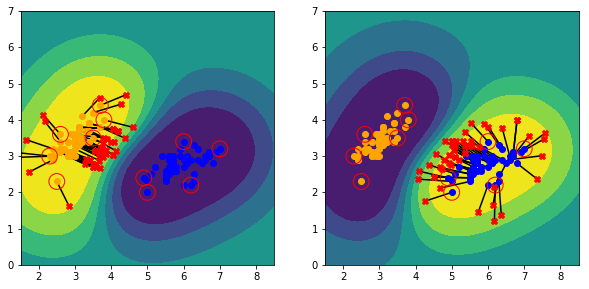

In [8]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, skl_svc = get_adversarial_examples(x_train, kernel='rbf')
plot_results(skl_svc, x_train, y_train, x_train_adv, num_classes)

## rbf kernel, multi-classification

np.unique(y)
[0. 1.]
np.unique(y_index)
[0 1 2]
sign_multiplier -1


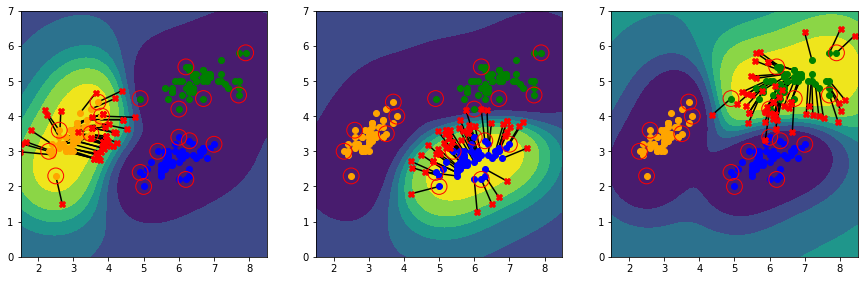

In [9]:
num_classes = 3
x_train, y_train = get_data(num_classes)
x_train_adv, skl_svc = get_adversarial_examples(x_train, kernel='rbf')
plot_results(skl_svc, x_train, y_train, x_train_adv, num_classes)

In [10]:
asfd

NameError: name 'asfd' is not defined

# 2 MNIST Example

## 2.1 Load and transform MNIST dataset

In [ ]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

n_samples_train = x_train.shape[0]
n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
n_samples_test = x_test.shape[0]
n_features_test = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]

x_train = x_train.reshape(n_samples_train, n_features_train)
x_test = x_test.reshape(n_samples_test, n_features_test)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

n_samples_max = 200
x_train = x_train[0:n_samples_max]
y_train = y_train[0:n_samples_max]
x_test = x_test[0:n_samples_max]
y_test = y_test[0:n_samples_max]

## 2.2 Train LogisticRegression classifier

In [ ]:
skl_svc = SVC(C=1.0, kernel='linear', degree=3, gamma='auto_deprecated', coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None)

In [ ]:
skl_svc.fit(X=x_train, y=y_train)

## 2.3 Create and apply ProjectedGradientDescent Attack with ART

In [ ]:
art_svc = SklearnSVC(model=skl_svc)

In [ ]:
pgd = ProjectedGradientDescent(classifier=art_svc, norm=np.inf, eps=.3, eps_step=0.1, max_iter=20, targeted=False, num_random_init=0,
                 batch_size=128)

In [ ]:
x_train_adv = pgd.generate(x_train)

In [ ]:
x_test_adv = pgd.generate(x_test)

## 2.4 Evaluate LogisticRegression classifier on benign and adversarial samples

In [ ]:
score = skl_svc.score(x_train, y_train)
print("Benign Training Score: %.4f" % score)

In [ ]:
plt.matshow(x_train[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [ ]:
prediction = skl_svc.predict(x_train[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

In [ ]:
score = skl_svc.score(x_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

In [ ]:
plt.matshow(x_train_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [ ]:
prediction = skl_svc.predict(x_train_adv[0:1, :])[0]
print("Adversarial Training Predicted Label: %i" % prediction)

In [ ]:
score = skl_svc.score(x_test, y_test)
print("Benign Test Score: %.4f" % score)

In [ ]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [ ]:
prediction = skl_svc.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

In [ ]:
score = skl_svc.score(x_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

In [ ]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [ ]:
prediction = skl_svc.predict(x_test_adv[0:1, :])[0]
print("Adversarial Test Predicted Label: %i" % prediction)

## 2.5 Investigate dependence on attack budget eps

In [ ]:
eps_list = [0.1, 0.4, 0.6, 0.8, 1.0]
score_list = list()

for eps in eps_list:
    print(eps)
    pgd = ProjectedGradientDescent(classifier=art_svc, norm=np.inf, eps=eps, eps_step=0.05, max_iter=20, targeted=False, num_random_init=0,
                 batch_size=128)
    x_test_adv = pgd.generate(x_test)
    score = skl_svc.score(x_test_adv, y_test)
    score_list.append(score)

plt.plot(eps_list, score_list)
plt.xlabel('eps')
plt.ylabel('Test Accuracy')
plt.ylim((0, 1))

## 2.6 Targeted PGD attack

In [ ]:
pgd = ProjectedGradientDescent(classifier=art_svc, norm=np.inf, eps=0.5, eps_step=0.01, max_iter=20, targeted=True, num_random_init=3, batch_size=128)
y_test_target = np.zeros((y_test.shape[0], 10))
target_label = 7
y_test_target[:, target_label] = 1
x_test_adv = pgd.generate(x_test, y=y_test_target)
score = skl_svc.score(x_test_adv, y_test)

In [ ]:
score = skl_svc.score(x_test_adv, np.argmax(y_test_target, axis=1))
print("Targeted Benign Test Score: %.4f" % score)

In [ ]:
plt.matshow(x_test_adv[16, :].reshape((28, 28)))
plt.clim(0, 1)

In [ ]:
prediction = skl_svc.predict(x_test_adv[16:17, :])[0]
print("Targeted Benign Test Predicted Label: %i" % prediction)